### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- playwright sted selenium
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [4]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [5]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-26 20:33:03,211 - AInewsbot - INFO - Initializing with before_date=2025-04-26 08:00, do_download=False, thread_id=486f3c2dc7184b3993553eddc26e9362
2025-04-26 20:33:03,312 - AInewsbot - INFO - thread_id: 486f3c2dc7184b3993553eddc26e9362


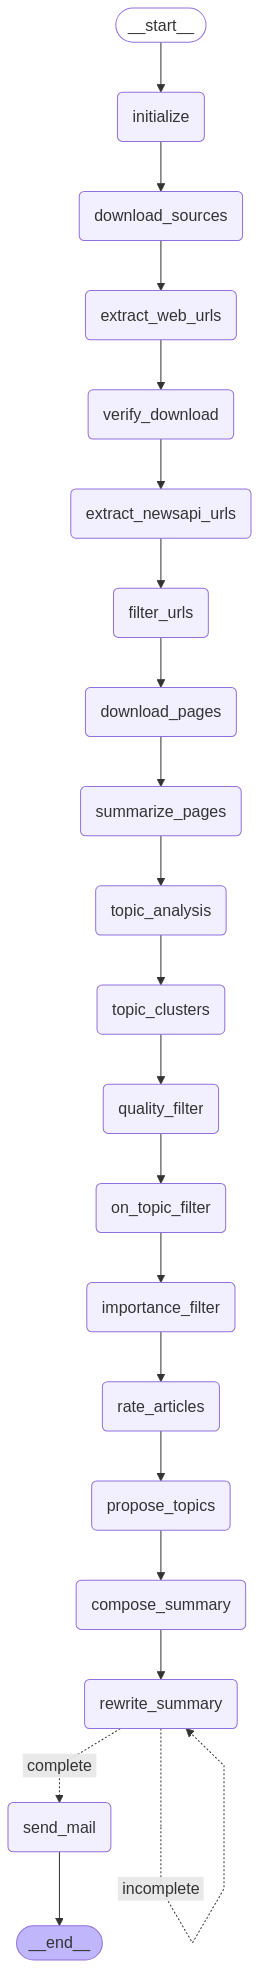

In [6]:
before_date = None
before_date = '2025-04-26 08:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-26 20:33:13,741 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-26 20:33:13,741 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-26 20:33:13,742 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-26 20:33:13,742 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-26 20:33:13,742 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-26 20:33:13,743 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-26 20:33:13,743 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-04-26 20:33:13,939 - AInewsbot - INFO - parse_file - found 82 raw links
2025-04-26 20:33:13,940 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-04-26 20:33:13,940 - AInewsbot - INFO - 19 links found
2025-04-26 20:33:13,941 - AInewsbot - INFO - Reddit -> htmldata/Reddit (04_26_2025 06_02_09 PM).html
2025-04-26 20:33:13,961 - AInewsbot - INFO - parse_file - found 422 raw links
2025-04-26 20:33:13,965 - AInewsbot - INFO - parse_file - found 167 filtered links
2025-04-26 20:33:13,965 - AInewsbot - INFO - 167 links found
2025-04-26 20:33:13,965 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme (04_26_2025 06_01_50 PM).html
2025-04-26 20:33:13,983 - AInewsbot - INFO - parse_file - found 449 raw links
2025-04-26 20:33:13,987 - AInewsbot - INFO - parse_file - found 193 filtered links
2025-04-26 20:33:13,988 - AInewsbot - INFO - 193 links found
2025-04-26 20:33:13,988 - AInewsbot - INFO - The Register -> htmldata/The Register (04_26_2025 06_01_59 PM).html
2025-04-26 20:33:1

,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,63
Feedly AI,38
Hacker News 1,20
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-26 20:33:14,112 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,63
Feedly AI,38
Hacker News 1,20
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-26 20:33:14,116 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-25T20:33:14 from NewsAPI


,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,63
Feedly AI,38
Hacker News 1,20
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-26 20:33:14,350 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-26 08:00'
2025-04-26 20:33:14,989 - AInewsbot - INFO - URLs in orig_df: 820
2025-04-26 20:33:14,993 - AInewsbot - INFO - Existing URLs in DB: 250743
2025-04-26 20:33:15,062 - AInewsbot - INFO - New URLs in df filtered by URL: 180
2025-04-26 20:33:15,193 - AInewsbot - INFO - Existing src+title: 31
2025-04-26 20:33:15,193 - AInewsbot - INFO - New URLs in df filtered by src+title: 149
2025-04-26 20:33:15,208 - AInewsbot - INFO - Found 148 unique new headlines
2025-04-26 20:33:15,210 - AInewsbot - INFO - Found 148 unique cleaned new headlines
2025-04-26 20:33:20,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:33:20,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:33:21,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Business Insider,1
FT,1
Feedly AI,26
Hacker News 1,1
NewsAPI,13
Reddit,3
The Register,1
WSJ,1


2025-04-26 20:33:21,199 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-26 20:33:21,234 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 2396
2025-04-26 20:33:21,235 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 2396
2025-04-26 20:33:21,235 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 2396
2025-04-26 20:33:21,235 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 2396
2025-04-26 20:33:39,280 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 20:33:39,280 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 20:33:39,280 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 20:33:39,281 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 20:33:39,281 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 20:33:39,282 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 20:33:39,282 - AInewsbot -

2025-04-26 20:34:28,085 - AInewsbot - INFO - Processing page 18: https://www.jpost.com/israel-news/defense-news/article-851549
2025-04-26 20:34:28,086 - AInewsbot - INFO - get_url(https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/) - starting get_url https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/
2025-04-26 20:34:28,086 - AInewsbot - INFO - get_url(https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school) - starting get_url https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school
2025-04-26 20:34:28,086 - AInewsbot - INFO - Processing page 19: https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach
2025-04-26 20:34:28,086 - AInewsbot - INFO - get_url(https://www.jpost.

2025-04-26 20:34:28,703 - AInewsbot - INFO - Processing page 36: https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147
2025-04-26 20:34:28,703 - AInewsbot - INFO - get_url(https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147) - starting get_url https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147
2025-04-26 20:34:28,703 - AInewsbot - INFO - Processing page 37: https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk
2025-04-26 20:34:28,704 - AInewsbot - INFO - get_url(https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk) - starting get_url https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk
2025

,id
src,
Business Insider,1
FT,1
Feedly AI,26
Hacker News 1,1
NewsAPI,13
Reddit,3
The Register,1
WSJ,1


2025-04-26 20:34:37,866 - AInewsbot - INFO - Starting summarize
2025-04-26 20:34:37,866 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-26 20:34:37,937 - AInewsbot - INFO - clean_html - Page title: "Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do
Social card title: "Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do
Social card description: A group of former employees and activists have sent a letter pleading with lawmakers to stop OpenAI from going private.

2025-04-26 20:34:38,195 - AInewsbot - INFO - Queuing 0: Page title: "Get Us All Killed": Former OpenAI Sta...
2025-04-26 20:34:38,214 - AInewsbot - INFO - clean_html - Page title: 10 AI Agents for Business Workflow Automation
Social card title: 10 AI Agents for Business Workflow Automation
Social card description: In this article, we have listed 10 of the best AI agents for business workflow automation that businesses can adopt, confi

2025-04-26 20:34:39,104 - AInewsbot - INFO - Queuing 16: Page title: How AI Agents Will Reshape the Enterpr...
2025-04-26 20:34:39,121 - AInewsbot - INFO - clean_html - Page title: I compared Adobe’s new Firefly Image Model 4 to ChatGPT’s image generator, and it’s like they went to the same art school | TechRadar
Social card title: I compared Adobe’s new Firefly Image Model 4 to ChatGPT’s image generator, and it’s like they went to the same art school
Social card description: Quality convergence in AI images

2025-04-26 20:34:39,149 - AInewsbot - INFO - Queuing 17: Page title: I compared Adobe’s new Firefly Image M...
2025-04-26 20:34:39,157 - AInewsbot - INFO - clean_html - Page title: IDF used AI to kill Hamas terrorist, find hostages in Gaza - Defense News - The Jerusalem Post
Social card title: IDF used AI to eliminate Hamas official, locate hostages, US and Israeli officials tell NYT
Social card description: The technology was implemented and developed by Unit 8200 engineers, who 

2025-04-26 20:34:40,860 - AInewsbot - INFO - clean_html - Page title: TSMC's 2nm process coming this year makes chip & AI firms happy
Social card title: TSMC's 2nm process coming this year makes chip & AI firms happy
Social card description: TSMC is currently one of the most renowned companies in the tech industry. Its factories produce chips for major names in segments such as mobile

2025-04-26 20:34:40,875 - AInewsbot - INFO - Queuing 33: Page title: TSMC's 2nm process coming this year ma...
2025-04-26 20:34:40,878 - AInewsbot - INFO - clean_html - Page title: The Jobs That Will Fall First As AI Takes Over The Workplace
Social card title: The Jobs That Will Fall First As AI Takes Over The Workplace
Social card description: Artificial intelligence is advancing at breakneck speed. The big question is how long it will take until technology dominates the job market. You should start…

2025-04-26 20:34:40,881 - AInewsbot - INFO - Queuing 34: Page title: The Jobs That Will Fall First As A

2025-04-26 20:34:43,725 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:43,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:43,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:43,975 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:43,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:44,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:44,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:44,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:44,238 - httpx 

2025-04-26 20:34:48,644 - AInewsbot - INFO - Summary for 4 (length 2455): • OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of $800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety conce

2025-04-26 20:34:48,648 - AInewsbot - INFO - Summary for 16 (length 9174): • AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”
2025-04-26 20:34:48,648 - AInewsbot - 

2025-04-26 20:34:48,654 - AInewsbot - INFO - Summary for 26 (length 29004): • AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.
2025-04-26 20:34:48,656 - AInewsbot - INFO - Summary for 27 (length 5150): • Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sh

2025-04-26 20:34:48,659 - AInewsbot - INFO - Summary for 37 (length 668): no content
2025-04-26 20:34:48,659 - AInewsbot - INFO - Summary for 38 (length 8749): • DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.
2025-04-26 20:34:48,660 - AInewsbot - INFO - Summary for 39 (length 5234): • The US government is pressuring the

,id
src,
Business Insider,1
FT,1
Feedly AI,26
Hacker News 1,1
NewsAPI,13
Reddit,3
The Register,1
WSJ,1


2025-04-26 20:34:48,672 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:34:52,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:55,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:57,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:34:57,732 - AInewsbot - INFO - 47 free-form topics extracted
2025-04-26 20:34:57,734 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:34:57,744 - AInewsbot - INFO - Canonical topic tv & film & movies
2025-04-26 20:34:57,745 - AInewsbot - INFO - Canonical topic lifestyle & travel
2025-04-26 20:34:57,745 - AInewsbot - INFO - Canonical topic language models
2025-04-26 20:34:57,746 - AInewsbot - INFO - 

2025-04-26 20:34:57,766 - AInewsbot - INFO - Canonical topic quantum computing
2025-04-26 20:34:57,766 - AInewsbot - INFO - Sending prompt for 102 canonical topics
2025-04-26 20:35:00,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1

2025-04-26 20:35:00,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:00,898 - httpx 

2025-04-26 20:35:02,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,063 - httpx 

2025-04-26 20:35:02,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,535 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:02,561 - httpx 

2025-04-26 20:35:03,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:03,247 - httpx 

,id
src,
Business Insider,1
FT,1
Feedly AI,26
Hacker News 1,1
NewsAPI,13
Reddit,3
The Register,1
WSJ,1


2025-04-26 20:35:07,998 - AInewsbot - INFO - Fetching embeddings for 47 headlines
2025-04-26 20:35:08,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-26 20:35:09,301 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-26 20:35:09,306 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-26 20:35:10,467 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-26 20:35:11,623 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-26 20:35:11,660 - AInewsbot - INFO - Found 1 clusters


,title_topic_str
0,"DeepMind UK staff seek to unionise and challenge defence deals and Israel links (Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk)"
1,"Googles DeepMind UK team reportedly seeks to unionize (Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk)"
2,"Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) (Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk)"


2025-04-26 20:35:12,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:12,314 - AInewsbot - INFO - I dub this cluster: DeepMind UK Staff Unionization Efforts
2025-04-26 20:35:12,478 - AInewsbot - INFO - Sending bullet points email
2025-04-26 20:35:13,432 - AInewsbot - INFO - ['DeepMind UK Staff Unionization Efforts']


bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:35:13,453 - AInewsbot - INFO - Starting quality filter
2025-04-26 20:35:23,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:23,534 - AInewsbot - INFO - value counts: {0: 44, 1: 3}
2025-04-26 20:35:23,535 - AInewsbot - INFO - retained 47 articles after applying quality filter


bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:35:23,539 - AInewsbot - INFO - Starting on-topic filter
2025-04-26 20:35:27,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:27,805 - AInewsbot - INFO - value counts: {1: 41, 0: 6}
2025-04-26 20:35:27,805 - AInewsbot - INFO - retained 47 articles after applying on-topic filter


bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:35:27,817 - AInewsbot - INFO - Starting importance filter
2025-04-26 20:35:32,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:32,137 - AInewsbot - INFO - value counts: {1: 31, 0: 16}
2025-04-26 20:35:32,138 - AInewsbot - INFO - retained 47 articles after applying importance filter


bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:35:32,154 - AInewsbot - INFO - Calculating article ratings


bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:35:32,166 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:35:32,168 - AInewsbot - INFO - Initial cluster topics: 
DeepMind UK Staff Unionization Efforts
2025-04-26 20:35:46,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:35:46,645 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
DeepMind UK Staff Unionization Efforts
DeepMind UK staff unionize
Enterprise AI agents adoption
AI-driven SaaS sales revolution
Phishing-as-a-service kits automate scams
OpenAI o3 location detection
Microsoft Copilot usage stalls
IDF uses AI for strikes
Coal power's AI energy comeback
TSMC 2nm chip rollout plan
xAI eyes $20B fundraising
Google AI Overviews disrupt web
US opposes EU AI Code
Ziff Davis sues OpenAI
Intel announces major layoffs
SSA's AI chatbot misfires
Adobe-LinkedIn content authenticity
Pe

bullets created


[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI Defense Contracts, AI Doom, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Unionization, Ethical Concerns In AI Development, Ethics, Gen AI, Google AI Surveillance Involvement, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Employees at DeepMind UK, Google's artificial intelligence subsidiary, are seeking to unionise in response to concerns over the company's involvement in defence contracts and links with Israel.  
• The unionisation effort follows DeepMind dropping its previous pledge not to pursue weapons or surveillance-related projects.



[Googles DeepMind UK team reportedly seeks to unionize - TechCrunch](https://techcrunch.com/2025/04/26/googles-deepmind-uk-team-reportedly-seeks-to-unionize/)

Topics: AI Doom, AI Military Applications, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deals, Deepmind Uk Labor Issues, Employee Activism In AI Companies, Ethics, Finance, Funding, Gen AI, Google And Israeli Military Contracts, Governance, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Uk

• Around 300 London-based members of Google’s DeepMind team are seeking to unionize with the Communication Workers Union due to concerns about Google removing its pledge not to use AI for weapons or surveillance and its work with the Israeli military, including a \\$1.2 billion cloud computing contract.

• At least five DeepMind staff members have reportedly quit over these issues, with one source stating team members feel “duped.”

• DeepMind employs about 2,000 people in the UK, and a Google spokesperson stated the company encourages “constructive and open dialogue with all of our employees.”



[Sources: ~300 London-based DeepMind staff sought to unionize with the CWU in recent weeks, to challenge AI sales to defense groups and Google's ties to Israel (Financial Times) - Twitter](https://t.co/Jm2tMOxoP8)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture, Uk

no content



[How AI Agents Will Reshape the Enterprise - WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)

Topics: AI Agents In Enterprise, AI Doom, AI Governance And Oversight, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Economics, Enterprise AI Adoption Challenges, Ethics, Finance, Gen AI, Governance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models In Business, Open Source, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Supply Chain Optimization, Virtual Assistants, Workflow Automation

• AI agents, powered by advanced large language models (LLMs) and orchestration technologies, are set to transform enterprise operations by autonomously managing knowledge, automating workflows, and handling software engineering tasks.
• Gartner predicts that by 2026, 30% of major enterprises will have at least one AI-augmented agent orchestrating cross-functional workflows, up from less than 5% today.
• Key challenges for enterprise adoption include integration with complex tech stacks, data privacy and compliance, evaluating agent effectiveness, and maintaining human oversight; solutions involve explainable AI, strong governance, and centaur (human-in-the-loop) architectures.
• Satya Nadella, CEO of Microsoft, emphasized, “We are entering the age of copilots and autonomous agents—the future will belong to those organizations that embrace this transformation holistically.”



[10 AI Agents for Business Workflow Automation - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/10-best-ai-agents-for-business-workflow-automation)

Topics: AI Productivity Tools, AI Security In Enterprise, AI Workflow Automation, Business Process Automation, Chatbots, Cybersecurity, Economics, Enterprise AI Tools, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, No-Code AI Integration, Open Source, Products, Robots, Supply Chain Optimization, Virtual Assistants

• The article lists 10 AI agents—Supervity AI, CortexON AI, Lecca, Globus AI, Sema4.ai, AgentLed AI, Respell AI, Spell, Agents AI, and Thinkeo—that provide workflow automation for businesses, each with specialized functions such as managing workflows, automating repetitive tasks, handling workforce management, building custom agents, and managing complex document creation.
• Features highlighted include autonomous workflow management, integration with popular business tools, no-code automation, advanced reasoning or collaborative multi-agent setups, open-source transparency, and security measures suitable for enterprise needs.
• The article emphasizes that these AI agents can be adopted immediately, with benefits such as increased efficiency, reduced manual workloads, and better allocation of employee focus, noting the rapid development and diversity of automation tools available to modern businesses.



[AI is Revolutionizing How SaaS is Sold to SMBs - WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

Topics: AI In Saas Sales, AI Productivity Tools, AI Sales Enablement, B2B Digital Sales Trends, Bias And Fairness, Customer Service, Data-Driven Marketing Tools, Deals, Economics, Ethics, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Products, Small And Medium Business Technology

• Artificial Intelligence is rapidly transforming how SaaS vendors sell to Small and Medium-sized Businesses (SMBs), helping companies leverage data-driven tools like 6sense, Apollo, Outreach.io, and Drift to personalize outreach, optimize pricing, and improve customer engagement.

• AI-powered sales enablement and automation have led to significant gains, with enterprises realizing up to a 50% increase in lead-to-customer conversion rates (McKinsey) and a 40% increase in open rates for AI-personalized outbound emails (HubSpot); AI-enhanced sellers are 2.1x more likely to outperform peers in engaging prospects (Salesforce).

• Adoption of AI requires addressing challenges such as ethical data use and maintaining human trust, with leaders advised to invest in AI tools, re-skill teams, prioritize high-quality data, and revise incentives as SMB technology spending is projected to reach \\$1.3 trillion globally (IDC), and Gartner forecasts that by 2025, 80% of B2B sales interactions will be digital.



[vivo details all of the AI features baked in to FunTouch OS 15 - GSMArena](https://www.gsmarena.com/vivo_details_all_of_the_ai_features_baked_in_to_funtouch_os_15_-news-67549.php)

Topics: AI Ocr Features, AI Photo Editing, AI Productivity Tools, Art & Design, Authors & Writing, China, Cognitive Science, Computer Vision, Customer Service, Education, Entertainment, Gen AI, Hardware, India, Language Models, Lifestyle & Travel, Products, Real-Time Translation, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Vivo Funtouch Os 15

• Vivo has detailed the AI features included in FunTouch OS 15, now available on vivo and iQOO devices, which include AI Erase (photo object removal), AI Live Cutout (subject isolation), AI Photo Enhance (photo improvement), Circle to Search (screen search via drawing), and AI Call Translation (real-time call translation with recording notification).

• Additional features are AI Screen Translation (real-time translation of on-screen content), AI Transcript Assist (audio-to-text conversion with summaries and keyword searches), AI Live Text (OCR text extraction from images), and AI Note Assist (note organization with bullet-points, summaries, to-do extraction, and translation).



[Consumers make their voices heard as Microsoft's huge Copilot venture flatlines in popularity - www.xda-developers.com](https://www.xda-developers.com/microsofts-huge-venture-flatlines/)

Topics: AI Productivity Tools, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Microsoft AI Product Marketing, Microsoft Copilot User Adoption, OpenAI Chatgpt Usage Comparison, Products, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Microsoft Copilot has plateaued at around 20 million weekly users, according to data shared by CFO Amy Hood at a recent executive meeting, representing just over 1% of Windows' 1.5 billion users.
• By comparison, OpenAI’s ChatGPT has reached approximately 400 million weekly users, highlighting Copilot's struggle to gain wider adoption despite being integrated across multiple Microsoft products and platforms.
• The stagnation in Copilot’s user base comes after substantial investment and efforts to promote it, including the launch of Copilot Pro, Copilot+ devices, and a dedicated keyboard key.



[Darcula adds AI to its DIY phishing kits to help would-be vampires bleed victims dryBecause coding phishing sites from scratch is a real pain in the neck - The Register](https://www.theregister.com/2025/04/25/darcula_ai/)

Topics: AI In Cybercrime, Cybersecurity, Cybersecurity Threats, Darcula Phishing Kit, Disinformation, Ethics, Gen AI, Legal Issues, Phishing Automation, Phishing Templates And Languages, Privacy, Privacy & Surveillance, Products, Scams

• Cybercrime group Darcula has updated its phishing-as-a-service kit with new AI features, allowing users to more easily create and translate phishing sites into multiple languages, as reported by Netcraft on April 23.

• The AI tools enable automatic generation and customization of phishing forms and improved cloning of website layouts, significantly lowering the technical barrier for less skilled criminals to conduct phishing attacks.

• Darcula's platform, which now offers over 200 phishing templates mimicking brands in more than 100 countries, also delivers phishing messages via iMessage and RCS to bypass SMS firewalls.

• "This addition lowers the technical barrier for creating phishing pages, enabling less tech-savvy criminals to deploy customized scams in minutes," said Netcraft analyst Harry Everett.



[Watching OpenAI's o3 guess a photo's location, including the model running Python code to examine license plates, is surreal, dystopian, and entertaining (Simon Willison/Simon Willison's Weblog) - Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)

Topics: AI Image Analysis, AI Tool Integration, Computer Vision, Entertainment, Gen AI, Language Models, Large Language Models, Lifestyle & Travel, OpenAI O3 Model, Photo Location Detection, Privacy, Privacy & Surveillance, Transformers, Travel

• OpenAI’s new o3 model can analyze photographs and make highly accurate guesses about their locations, even without visible landmarks or EXIF metadata, by identifying subtle visual cues and running code to zoom in on details like license plates.

• The article demonstrates o3 correctly identifying a photo taken in El Granada, California, after reasoning through environmental features and architecture, and notes similar capabilities in other large language models like Claude and Gemini, though o3 stands out for its integrated, iterative tool use.

• The writer discovered o3 now has access to a user’s rough location as part of its search features but confirmed the model’s location-guessing abilities remain impressive even for photos taken far from the user’s current location.



[AMD set to launch new Radeon Pro W9000 workstation GPU to take on Nvidia's formidable RTX Pro 6000 Blackwell Workstation Edition - TechRadar](https://www.techradar.com/pro/amd-set-to-launch-new-radeon-pro-w9000-workstation-gpu-to-take-on-nvidias-formidable-rtx-pro-6000-blackwell-workstation-edition)

Topics: Amd Radeon Pro W9000, Art & Design, Entertainment, Gen AI, Hardware, Jobs & Careers, Manufacturing, Nvidia Rtx Pro Comparison, Open Source, Products, Rdna 4 Architecture, Semiconductor Chips, Taiwan, Tv & Film & Movies, Video Editing Hardware, Workstation Gpus

• A leaked report suggests AMD will soon launch the Radeon PRO W9000 workstation GPU, featuring a 32GB memory limit and built on the RDNA 4 architecture, targeting professionals in video editing, 3D rendering, and production tasks rather than data science or AI-heavy workflows.
• The W9000, based on the Navi 48 XTW architecture with a 356mm² die size, is expected to prioritize performance per dollar and efficiency over matching Nvidia’s competing RTX PRO 6000 Blackwell, which offers 96GB memory; the W9000 will come in several variants (XL, XT, XTX, XTW) tailored to different professional needs.
• Official details such as final specs and software support (including full RDNA 4 integration with the ROCm platform) remain unconfirmed, but AMD is anticipated to announce the W9000 lineup at Computex 2025 and its “Advancing AI” event in June 2025.



[NYT Asks: Should We Start Taking the Welfare of AI Seriously? - slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)

Topics: AI Doom, AI Welfare Research, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethical AI Considerations, Ethics, Gen AI, Google AI Research, Governance, Language Models, Large Language Models, Machine Consciousness, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI company Anthropic and others in the tech industry are beginning to study "model welfare," considering whether advanced AI systems could deserve moral consideration or rights if they approach consciousness.
• Anthropic has hired an AI welfare researcher and maintains internal discussions on potential AI consciousness, with company leaders like Jared Kaplan stating it's "pretty reasonable" to study the issue as AI models become more sophisticated.
• Google recently posted a job opening for a "post-AGI" research scientist focused partly on machine consciousness, reflecting a growing interest in AI welfare among tech companies and experts in philosophy and neuroscience.



[IDF used AI to eliminate Hamas official, locate hostages - The Jerusalem Post](https://www.jpost.com/israel-news/defense-news/article-851549)

Topics: Bias And Fairness, Cognitive Science, Ethical Concerns In AI Warfare, Ethics, Gen AI, Governance, Hostage Location Technology, Idf AI Military Applications, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Targeted Killings Using AI

• The IDF's Unit 8200 used AI technology to track and kill Hamas commander Ibrahim Biari, who was involved in planning the October 7, 2023 attacks on southern Israel, and to locate hostages in Gaza, according to Israeli and US officials cited by The New York Times.

• The AI tool, developed by Unit 8200 engineers and refined over time, utilized intercepted calls to locate Biari and hostages, and was deployed shortly after the October 7 attacks; the strike on Biari also killed 50 other terrorists.

• US and Israeli officials acknowledged that the use of AI in warfare has led to civilian deaths due to mistaken identification, raising ethical concerns, with calls for responsible use articulated by both IDF spokespeople and experts in responsible AI.



[Creative Destruction: Why AI Will Unleash Marketing Creativity and Opportunities - martech.zone](https://martech.zone/creative-destruction/)

Topics: AI Impact On Marketing, AI Productivity Tools, AI-Driven Marketing Roles, Art & Design, Authors & Writing, Bias And Fairness, Creative Destruction In Marketing, Customer Service, Economics, Entertainment, Ethical Marketing Oversight, Ethics, Finance, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Marketing Automation Technologies, Opinion, Products, Society & Culture, Speech Recognition & Synthesis, Virtual & Augmented Reality

• The article argues that AI is ushering in a phase of "creative destruction" in marketing, automating repetitive roles while generating demand for new positions such as AI prompt engineers, marketing automation architects, and data ethicists.

• Advances in AI, including machine learning, natural language processing, and generative AI, are expanding marketing opportunities through new mediums (AR/VR, voice assistants), sophisticated strategies (predictive and prescriptive marketing, micro-targeting), and automation, which allows marketers to focus on high-value creative tasks.

• The author emphasizes that marketers remain essential for providing creativity, emotional resonance, and ethical oversight, predicting that future marketing teams will be smaller, more specialized, and blend human skills with AI proficiency rather than being replaced by AI.



[Silicon Valleys intense energy demands for AI are making coal-fired power plants a hot-ticket item again - Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

Topics: AI Electricity Demand, Climate, Coal Power Plants, Data Center Power Needs, Deals, Economics, Energy, Energy Infrastructure, Energy Transition, Finance, Funding, Governance, Hardware, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Manufacturing, Nuclear, Policy And Regulation, Politics, Products, Smart Grid, Society & Culture, Sustainability, Transportation

• Surging electricity demand from AI and cloud computing has made retired coal-fired power plants valuable for their existing connections to the power grid, attracting interest from tech companies, investors, and utilities looking to quickly bring new power sources online.

• President Trump has used emergency authority to encourage utilities to keep older coal-fired plants operational, while federal incentives such as tax credits and loan guarantees promote redeveloping retired coal plant sites for gas, nuclear, solar, or battery storage facilities.

• Examples include conversions to natural gas (in Pennsylvania and the South), battery storage (in Alabama), wind (in New Jersey and Massachusetts), solar (in Illinois), and possible nuclear projects (in Arizona and Indiana), with economic advantages and potential for retraining former coal plant workers.

• In Homer City, Pennsylvania, a recently closed coal plant site will host a \\$10 billion natural gas-powered data center campus, aiming to revitalize the local economy and community.



[DeepSeeks success shows why motivation is key to AI innovation - VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)

Topics: AI Productivity Tools, Artificial General Intelligence, Chatbots, China, Chinese AI Innovation, Cognitive Science, Deepseek AI Model, Energy, Energy-Efficient AI Training, Funding, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Model Optimization, Large Language Models, Products, Reinforcement Learning, Reinforcement Learning Simplification, Retrieval Augmented Generation, Review, Semiconductor Chips, Testing

• In January 2025, Chinese company DeepSeek surprised the AI industry by challenging OpenAI and other U.S. tech giants with its DeepSeek-R1 large language model, which, while slightly behind in benchmarks, offered significantly improved hardware and energy efficiency.

• DeepSeek achieved these cost savings through technical innovations including optimization of the Key-Value (KV) cache in attention layers and implementation of mixture-of-experts (MoE) models, allowing more efficient GPU memory use and computation.

• DeepSeek also reduced training costs by simplifying reinforcement learning processes, using tagged thought and answer segments to minimize the need for expensive, manually annotated training data, which led to high-quality answer generation after an 'a-ha' breakthrough in model behavior.

• OpenAI has suggested DeepSeek may have used OpenAI’s models for training, but there is no concrete proof; DeepSeek’s results have been independently verified at smaller scales.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: AI For Child Safety, Authors & Writing, Bias And Fairness, Big Tech European Union Fines, Chatbots, Economics, Entertainment, Ethics, European Union, Finance, Gen AI, Google Monopoly Case, Governance, Hollywood, Inequality, Language Models, Large Language Models, Legal Issues, Music, OpenAI Chatgpt Operational Costs, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Space Tourism Celebrities, Speech Recognition & Synthesis, Travel, Tv & Film & Movies, Us Justice Department Antitrust Actions, Virtual Assistants

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT, such as saying "please" and "thank you," collectively adds millions of dollars to operational costs.
• The U.S. Justice Department requested a federal judge to break up Google, following a ruling that found Google maintains an illegal monopoly in online search by paying browsers and manufacturers to prioritize its search engine.
• Six women, including pop star Katy Perry and CBS’s Gayle King, participated in a Blue Origin space flight; Perry plans to write a song about the experience, while King declined the "astronaut" label.
• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, a major antitrust law aimed at curbing anticompetitive practices by Big Tech companies.
• Instagram announced it will deploy AI to identify teenagers using adult settings in an effort to address ongoing child safety concerns.



[I compared Adobes new Firefly Image Model 4 to ChatGPTs image generator, and its like they went to the same art school - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)

Topics: Adobe Firefly Image Model 4, AI-Generated Images Comparison, Art & Design, Chatgpt Image Generation, Computer Vision, Entertainment, Food & Drink, Gen AI, Generative AI Art Models, Hollywood, Language Models, Large Language Models, Opinion, Products, Review, Robots, Tv & Film & Movies

• A comparison of Adobe’s new Firefly Image Model 4 and ChatGPT’s upgraded image generator found that both produce highly similar, high-quality AI-generated images across various prompts, including portraits, complex scenes, food, and fantasy subjects.  
• Differences surfaced in emphasis: Firefly focused more on certain scene elements (e.g., robotics), while ChatGPT excelled in integrating specified details such as text in fiery letters and more dynamic poses.
• The article concludes that image quality and results from both models have converged to a level where choosing between them is mainly down to budget or company preference, rather than clear differences in output quality.



["Get Us All Killed": Former OpenAI Staffers Implore Courts to Block What It's Trying to Do - Futurism](https://futurism.com/openai-staffers-court-nonprofit)

Topics: AI Doom, Artificial General Intelligence, Artificial General Intelligence Risks, Cognitive Science, Consciousness, Economics, Ethics, Finance, For-Profit Vs Nonprofit AI Companies, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal And Ethical AI Oversight, Legal Issues, Open Source, OpenAI Corporate Restructuring, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Singularity, Society & Culture, Stocks

• A group of former OpenAI employees, law professors, activists, and Nobel Prize winners have sent a letter urging the California and Delaware attorneys general to stop OpenAI from restructuring into a fully for-profit company.
• The letter warns that OpenAI's pursuit of Artificial General Intelligence (AGI) could pose existential risks, with former employee Nisan Stiennon stating, "OpenAI may one day build technology that could get us all killed."
• Critics argue that as a nonprofit, OpenAI's directors have a legal duty to benefit humanity, but as a for-profit public benefit corporation, they would not be strictly bound to uphold this duty, potentially prioritizing shareholder interests instead.



[University of Waterloo withholds coding contest results over suspected AI use - The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

Topics: Academic Integrity, AI Productivity Tools, AI-Generated Code, Cheating In Education, Code Assistants, Coding Competition, Education, Ethics, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Society & Culture, Testing, University Of Waterloo

• The University of Waterloo has withheld the results of a prestigious coding competition due to suspicions of widespread cheating involving students submitting code they did not write, potentially generated by artificial intelligence tools.
• Organizers cited "concerning patterns" among submissions and rule-breaking, raising issues about the role of AI technologies in academic integrity.



[US wants to nix the EU AI Acts code of practice, leaving enterprises to develop their own risk standards - Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)

Topics: AI Compliance Standards, AI Doom, AI Productivity Tools, Artificial General Intelligence, Bias And Fairness, Books & Publishing, Cybersecurity, Deals, Disinformation, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Regulatory Impact On AI Innovation, Safety And Alignment, Singularity, Society & Culture, Testing, Transatlantic AI Policy, Us-Eu AI Regulation

• The US government is pressuring the European Union to scrap the draft code of practice for the EU AI Act, arguing that it imposes burdensome obligations—such as third-party model testing and disclosure of full training data—that go beyond the Act's legally binding requirements and could stifle innovation.

• The EU AI Act's draft code of practice, developed by a range of stakeholders and overseen by the European AI Office, is intended to provide voluntary but enforceable guidelines for AI providers on transparency, copyright, and risk management; non-compliance could lead to fines up to 7% of global revenue when it takes effect in August.

• The US position reflects a broader trend toward lighter regulation; following Executive Order 14179, the US updated its AI guidance to reduce regulatory emphasis on AI safety and fairness, instead focusing on reducing bias and supporting economic competitiveness.



[Ziff Davis and IGN sue OpenAI for copyright infringement - VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

Topics: AI Training Data, Authors & Writing, Books & Publishing, Copyright Infringement, Deals, Disinformation, Dmca Violations, Economics, Entertainment, Ethics, Finance, Gaming, Gen AI, Governance, Healthcare, Intellectual Property, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Products, Society & Culture, Tv & Film & Movies, Ziff Davis Lawsuit

• Ziff Davis, along with its divisions IGN Entertainment and Everyday Health Media, has filed a lawsuit against OpenAI alleging copyright infringement, DMCA violations, unjust enrichment, and trademark dilution.
• The lawsuit claims OpenAI reproduced and created derivatives of Ziff Davis’ works without authorization, ignored written demands to stop, stripped copyright management information, and falsely attributed non-original content to Ziff Davis.
• A spokesperson for OpenAI responded that its models are trained on publicly available data and grounded in fair use, emphasizing their societal benefits; Ziff Davis maintains that its content was protected by a robots.txt file and exclusive rights.



[TSMC's 2nm process coming this year makes chip & AI firms happy - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)

Topics: AI Productivity Tools, Artificial General Intelligence, Deals, Economics, Finance, Gate-All-Around Transistors, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Manufacturing, Next-Gen AI Chips, Products, Semiconductor Advancements, Semiconductor Chips, Stocks, Taiwan, Tsmc 2Nm Process

• TSMC announced at the North American Technology Symposium 2025 that its 2nm (N2) chip production process is ready, with mass production set to begin in the second half of 2025.
• The 2nm process will debut TSMC's gate-all-around (GAA) nanosheet transistors and is expected to deliver 10–15% better performance, 25–30% lower power consumption, and 15% higher transistor density compared to its current 3nm (N3E) technology.
• Key industry players such as NVIDIA, AMD, Qualcomm, and Apple plan to use TSMC's 2nm chips for next-generation AI, data center, and mobile processors, with enhanced N2P and N2X versions scheduled for 2026 and 2027.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Chatbot Integration, AI Productivity Tools, Algorithmic Errors In Public Services, Artificial General Intelligence, Automation Challenges, Bias And Fairness, Chatbots, Code Assistants, Customer Service, Cybersecurity, Disinformation, Economics, Education, Ethics, Federal Services AI, Finance, Gen AI, Governance, Healthcare, History, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Singularity, Social Security Administration, Society & Culture, Testing, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI chatbot, the Agency Support Companion, into staff workflows to assist with everyday tasks, but employees report it is unreliable, with a poorly made training video and guidance that failed to warn against uploading sensitive information, prompting an apologetic follow-up email from the agency.

• The push for SSA automation is linked to the influence of Musk-backed DOGE, which seeks to cut federal staff and replace them with automation, a strategy that has contributed to administrative chaos such as erroneously marking millions of living benefit recipients as dead and suspending their benefits, requiring complex procedures to reinstate them.

• International parallels are drawn with Brazil's Meu INSS social security app, where algorithmic decisions have mistakenly denied rightful claims and created access problems for rural populations, raising concerns that similar automation in U.S. social services may worsen outcomes.



[Perplexitys CEO on fighting Google and the coming AI browser war - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistant Partnerships, AI Productivity Tools, Artificial General Intelligence, Books & Publishing, Chatbots, Code Assistants, Cybersecurity, Deals, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Google Antitrust Impact, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Mobile AI Integration, Perplexity AI Browser, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search Engine Competition, Singularity, Streaming, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced plans to launch the company's own AI-powered browser, Comet, next month to compete in what he calls the next AI battleground and enhance agent capabilities by operating more deeply at the browser level.

• Perplexity struck a deal with Motorola to have its AI assistant pre-installed on new Razr phones, an opportunity enabled by increased antitrust scrutiny on Google; Srinivas stated, “If Google had not gone through the DOJ trial, we wouldn’t have been able to make this partnership happen.”

• Perplexity has grown from 1 million to nearly 30 million monthly active users over the past year, now handling about 600 million queries a month, or roughly 14 percent of Google’s query volume.

• Srinivas criticized the difficulty of replacing default assistants on Android due to Google’s dominance, and said the company is seeking more distribution partnerships, including talks with Samsung and other OEMs, and plans to launch browser versions for Mac and Windows.

• On scraping publisher content, Srinivas said Perplexity is now respecting robots.txt files and has started paying some publishers, but acknowledged more needs to be done to address publisher concerns.



[MyPillow CEO's Lawyer Embarrassed In Court After Judge Grills Him Over Using AI In Legal Filing - HuffPost](https://www.huffpost.com/entry/mike-lindell-mypillow-ai-lawsuit_n_680bf302e4b036223d52149f)

Topics: AI In Legal Filings, AI Productivity Tools, AI-Generated Legal Documents, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Courtroom AI Use Controversy, Cybersecurity, Disinformation, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Legal Ethics And AI, Legal Issues, Mypillow Defamation Case, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Society & Culture, Testing

• Colorado District Judge Nina Y. Wang criticized MyPillow CEO Mike Lindell's legal team for submitting a court brief partially generated by AI that contained nearly 30 defective citations, including references to non-existent cases, in a defamation lawsuit filed by former Dominion Voting Services employee Dr. Eric Coomer.  
• Lindell's attorney, Christopher I. Kachouroff, admitted in a court hearing to using generative AI in preparing the document and was ordered to show cause why Lindell and his companies should not be sanctioned and why the attorneys should not be referred to disciplinary proceedings.  
• In response, Kachouroff argued there is “nothing wrong with using AI when used properly,” claimed the submitted brief was an earlier draft filed by mistake, and described his surprise and embarrassment at being questioned in court about the AI-generated document.



[Robot Dexterity Still Seems Hard - www.construction-physics.com](https://www.construction-physics.com/p/robot-dexterity-still-seems-hard)

Topics: Autonomous Vehicles, Computer Vision, Drones, Hardware, Humanoid Robots, Job Automation, Manufacturing, Products, Robot Dexterity Challenges, Robot Sensory Limitations, Robotic Manipulation, Robots, Transportation

• Despite significant investment and an increasing number of companies building humanoid robots, most current robots struggle with dexterous manipulation and remain far less capable than humans at handling complex, variable tasks.

• Demonstrations of humanoids like those from Boston Dynamics, Figure, Tesla, and 1X Technologies often focus on locomotion or moving large objects, while tasks requiring fine motor skills—such as folding a shirt or pouring liquids—are performed imprecisely or under human teleoperation.

• Experts note that while robots excel in vision, strength, and precise, repeatable movements, major limitations remain in tactile sensing and proprioception, with robotic hands lacking the sensitivity, sensor density, and nuanced feedback of human hands, making dexterity the key unsolved challenge for useful general-purpose humanoid robots.



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Code Release, AI Productivity Tools, Artificial General Intelligence, Authors & Writing, Cognitive Science, Computer Vision, Education, Facebook Research, Gen AI, Image And Audio Captioning, Language Models, Large Language Models, Multimodal AI, Music, Open Source, Products, Singularity, Speech Recognition & Synthesis, Streaming, Testing, Tv & Film & Movies

• Facebook Research has released the official code implementation for the paper "LLMs can see and hear without any training," allowing users to run the MILS inference-only method for image, audio, and video captioning and high-quality image generation tasks.

• The code utilizes established datasets such as MS-COCO, Clotho, and MSR-VTT, and demonstrates how large language models (LLMs) can process visual and audio data without additional training by converting media input to text captions and prompts for further generation tasks.

• The paper and code are authored by Ashutosh Kumar, Yossi Gandelsman, Xinlei Chen, Ishan Misra, and Rohit Girdhar, and are available under a CC-by-NC 4.0 license with a preprint at arXiv:2501.18096.



[agixt 1.7.8 - pypi.org](https://pypi.org/project/agixt/1.7.8/)

Topics: Agixt Platform, AI Automation, AI Doom, AI Productivity Tools, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Gaming, Gen AI, Governance, Hardware, Job Automation, Language Models, Large Language Models, Multi-Model AI Orchestration, Music, Open Source, Open-Source AI Tools, Products, Reinforcement Learning, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Transformers, Virtual Assistants

• AGiXT is an open-source Artificial Intelligence Automation Platform designed for dynamic AI instruction management, task execution, and interoperability across multiple AI models and providers, including OpenAI, Hugging Face, Google Gemini, and more.

• Key features include adaptive memory handling, advanced task and chain management, integrated web browsing, audio-to-text/text-to-speech options, a versatile plugin system, RESTful API, Docker deployment, multi-provider compatibility, and support for code evaluation and custom prompts.

• The platform aims to streamline the orchestration of complex workflows and accelerate the realization of Artificial General Intelligence (AGI), with regular updates to expand its capabilities and provider support.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Adoption In Business, AI Financial Returns, AI Productivity Tools, Economics, Enterprise AI Impact On Revenue, Finance, Funding, Gen AI, Jobs & Careers, Mckinsey State Of AI Survey, Products

• According to McKinsey’s State of AI survey released in March, 78% of companies used artificial intelligence in at least one function as of last year, up from 55% in 2023.
• Despite high adoption rates, companies reported limited financial returns from AI, with typical cost savings of less than 10% and revenue increases of less than 5%.



[The Robot Vacuum Arms Race Is Over, and the Incredible AI-Powered Roborock Saros Z70 Has Won - Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)

Topics: AI Productivity Tools, AI-Powered Robot Vacuum, Art & Design, Artificial General Intelligence, Computer Vision, Customer Service, Deals, Drones, Entertainment, Funding, Gen AI, Hardware, Home Automation, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Products, Review, Roborock Saros Z70, Robotic Arm Technology, Robots, Society & Culture, Transportation

• Roborock has launched the Saros Z70, the world's first mass-produced robot vacuum equipped with an intelligent, foldable robotic arm (OmniGrip) capable of identifying, picking up, and moving obstacles, as well as updating its internal maps in real time using advanced AI.
• The Saros Z70 can recognize and remember up to 108 household objects, customize actions for 50 of them via an app, and handle cleaning tasks with powerful suction, advanced mopping features, and a low profile (under 3 inches) to access tight spaces.
• The Saros Z70 debuted at CES 2025 and is now available for purchase at a special launch price of \\$1,999 (23% discount from \\$2,599), with only 10 units released daily; it also won several iF DESIGN AWARD 2025 honors for innovation.



[The Jobs That Will Fall First As AI Takes Over The Workplace - biztoc.com](https://biztoc.com/x/00582fc58d3ace9a)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market

no content



[Identifying Technological Convergence in Cybersecurity: A Novel Approach - Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

Topics: Bibliometric Analysis In Cybersecurity, Blockchain And Cryptography, Cryptocurrency, Cybersecurity, Cybersecurity Technological Convergence, Economics, Finance, Fintech, Funding, Governance, History, Intellectual Property, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Testing, Text Mining For Tech Trends

• Researchers have developed a novel approach that combines text mining and bibliometric analysis to quantitatively analyze and predict technological convergence in cybersecurity, using the OpenAlex database to track the evolution of encryption technologies from 2002 to 2022.

• The study demonstrates a significant convergence between blockchain and public-key cryptography, as indicated by increasing proximity indices, aligning with the growing integration of public-key cryptography in blockchain ecosystems.

• The findings offer strategic insights for investment decisions and technological development in cybersecurity, with the authors noting their approach helps identify early stages of convergence and trends missed by traditional patent analysis.



[TSMC unveils plans for giant AI chips to meet surging compute demands - TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)

Topics: Advanced Semiconductor Packaging, AI Chip Performance, AI Productivity Tools, Artificial General Intelligence, Computer Vision, Cowos-L Packaging, Deals, Economics, Finance, Gen AI, Hardware, High-Bandwidth Memory, Internet Of Things, Language Models, Large Language Models, Manufacturing, Products, Semiconductor Chips, Stocks, Taiwan, Tsmc Chip Technology

• TSMC announced plans to launch next-generation CoWoS-L chip packaging technology as early as next year, enabling construction of multi-chiplet processors with interposers up to 4,719 mm²—roughly 5.5 times the current photomask reticle limit—allowing for up to 12 stacks of high-bandwidth memory and over 3.5 times the compute performance of today’s top chips.

• The company revealed further ambitions for an even larger package with a 7,885 mm² interposer on a 120×150 mm substrate, nearly twice its previous largest, capable of hosting four 3D-stacked systems, twelve HBM4 memory stacks, and multiple I/O dies, with the potential to power future processors such as Nvidia’s Rubin GPUs.

• To address power delivery and thermal challenges of these larger chips, TSMC is embedding advanced power management circuits using N16 FinFET technology and developing integrated immersion cooling solutions, though adapting to new substrate sizes and effective cooling integration remain significant engineering hurdles.



[Elon Musks xAI Set to Raise \\$20 Billion - Inc.](https://www.inc.com/reuters/elon-musks-xai-set-to-raise-20-billion/91181497)

Topics: Artificial General Intelligence, Deals, Economics, Elon Musk Xai Fundraising, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Opinion, Politics, Products, Social Media AI Acquisitions, Society & Culture, Stocks, Twitter Rebranding, Venture Capital, Xai Corporate Valuation

• Elon Musk's xAI Holdings is in talks with investors to raise roughly \\$20 billion, which would value the company at over \\$120 billion, according to Bloomberg News.
• The fundraising comes after xAI acquired X (formerly Twitter) last month in a deal valuing the social media platform at \\$33 billion, enabling xAI's value to be shared with co-investors.



[Google Is Burning the Internet to Save Itself  And AI Is the Match - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/google-is-burning-the-internet-to-save-itself-and-ai-is-the-match.html)

Topics: AI Impact On Web Traffic, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Content Creation And AI Ethics, Digital Advertising Revenue, Economics, Ethics, Finance, Funding, Gen AI, Google AI Search Strategy, Governance, Inequality, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Speech Recognition & Synthesis

• Google has shifted its search strategy by launching AI Overviews, which provide direct answers to user queries at the top of search results, resulting in significant drops in website traffic and threatening the traditional open web ecosystem.

• The move to AI-driven search is a defensive reaction to competition from chatbots like ChatGPT and Perplexity, with experts calling it an "extinction-level event" for both Google and publishers who rely on web traffic for revenue.

• Google's advertising business, which generated over \\$237 billion in 2024, is at risk as AI-generated answers reduce ad impressions and user clicks, with some publishers reporting traffic declines of over 60% for queries handled by AI Overviews.

• Google CEO Sundar Pichai has stated that AI will improve, not replace, search; however, critics argue that Google's approach is harming content creators, small businesses, and journalists by leveraging their work to train AI and giving users answers without credit or referral traffic.



[These 8 Free AI Apps Are Shockingly Good (and Totally Underrated) - Flipboard](https://flipboard.com/@muo_official/these-8-free-ai-apps-are-shockingly-good-and-totally-underrated-ajb14qbmhl5gq3nk)

Topics: Artificial General Intelligence, Gen AI, Language Models

no content



[Networking the right way can help make your own luck in your career, says this former Meta engineer - Business Insider](https://www.businessinsider.com/networking-career-advice-luck-ex-meta-engineer-rahul-pandey-startup-2025-4)

Topics: Authors & Writing, Career Decision-Making, Career Networking, Education, India, Jobs & Careers, Labor Market, Meta Engineer Insights, Opinion, Professional Growth Strategies, Society & Culture

• Rahul Pandey, former staff engineer at Meta and co-founder of Taro, emphasized on "The Developing Dev" podcast that networking with genuine curiosity and thoughtful sharing can help professionals create their own career luck, rather than relying solely on chance.  
• Pandey advocates approaching career decisions by considering which path offers more unique opportunities and storytelling potential, describing most career moves as "two-way doors" that allow for experimentation and course correction.  
• Key quote: "You create gravity. People gravitate toward you because they want to get your opinion on things, too. So it's like a two-way street."



[Third Of Chinas Farms Sprayed By Drones, Marking Agricultural Revolution - CleanTechnica](https://cleantechnica.com/2025/04/25/third-of-chinas-farms-sprayed-by-drones-marking-agricultural-revolution/)

Topics: Agriculture, China, Climate, Deals, Dji Agricultural Drones, Drones, Economics, Environmental Impact Of Drones, Farm Automation, Finance, Food & Drink, Funding, Governance, Government Drone Subsidies, Hardware, Health & Fitness, History, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Politics, Precision Agriculture, Products, Society & Culture, Sustainability, Transportation

• DJI's agricultural drones now spray one-third of all farmland in China, marking a major shift toward automation and precision in farming.  
• Drone spraying has delivered substantial economic and environmental benefits, including up to 30% reductions in chemical usage, significant cost savings for farmers, minimized soil compaction, and a reported reduction in CO₂ emissions equivalent to planting 1.2 billion trees.  
• Supported by Chinese government subsidies and favorable regulations, the adoption of drones in agriculture has grown rapidly, with over 300,000 DJI agricultural drones deployed globally as of late 2023; similar trends are beginning to emerge in North America and Europe as regulatory barriers decrease.



[IndiaAI GPU tender: Lowest bidders receive AI workloads - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/indiaai-gpu-tender-lowest-bidders-receive-ai-workloads/articleshow/120627587.cms)

Topics: AI Workload Providers, Customer Service, Deals, Economics, Finance, Funding, Gen AI, Governance, Government AI Procurement, Gpu Cloud Computing, Hardware, India, Indiaai Mission, Infrastructure, Jobs & Careers, Policy And Regulation, Politics, Products, Stocks

• Under the IndiaAI Mission, the Ministry of Electronics and Information Technology (MeitY) assigned AI computing projects to Yotta, E2E Networks, and NxtGen, offering subsidised GPU access at less than \\$1 per hour—the lowest rate globally.
• These three companies will collectively supply over 11,600 GPUs and are currently the only providers integrated with the government's IndiaAI Compute Portal; Yotta will provide 9,216 GPUs, E2E 1,353, and NxtGen 1,088.
• Service provider workloads will be assigned based on bidder ranking, starting with the lowest (L1); access must be provided by August, and additional rounds are planned to expand procurement beyond the initial 10,000 GPU target, with the government having already secured commitments for 18,693 GPUs.



[LinkedIn and Adobe announce partnership to help creators protect their work against AI - Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

Topics: AI Misinformation Prevention, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content Authenticity, Creator Identity Verification, Cybersecurity, Deals, Digital Content Protection, Disinformation, Entertainment, Ethics, Gen AI, Governance, Intellectual Property, Jobs & Careers, Legal Issues, Linkedin-Adobe Partnership, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Adobe and LinkedIn have partnered to integrate LinkedIn's free identity verification tool into Adobe's content authenticity app, allowing creators to display a "Verified on LinkedIn" badge to help protect their work and verify their identity across platforms.  
• Verified creators can add credentials through Adobe’s content authentication system, automatically attaching content provenance and identity verification to their work when posted on LinkedIn and other platforms.  
• The partnership is part of broader efforts, including TikTok and other tech companies, to combat AI-driven misinformation by joining initiatives like the Content Authenticity Initiative and the Coalition for Content Provenance and Authenticity (C2PA).



[Meta, Booz Allen develop Space Llama AI system for the International Space Station - SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

Topics: AI Productivity Tools, Artificial General Intelligence, Autonomous Vehicles, Booz Allen, Code Assistants, Cognitive Science, Computer Vision, Deals, Funding, Gen AI, Hardware, International Space Station AI, Language Models, Large Language Models, Meta AI, Military, Open Source, Products, Singularity, Space Llama System, Space Research Technology, Transformers

• Meta Platforms and Booz Allen have partnered to develop "Space Llama," an AI system based on Meta's Llama 3.2 language model, for use aboard the International Space Station (ISS).
• Space Llama is designed to support research in the ISS National Laboratory by helping astronauts extract data from technical documents and process multimodal files, operating independently of Earth-based instructions.
• The AI system runs on Hewlett Packard Enterprise's Spaceborne Computer-2, optimized for limited processing environments, and aims to enhance scientific projects relevant to space exploration, satellite, and autonomous system development.



[Unauthorized experiment on CMV involving AI-generated comments - Reddit](https://www.reddit.com/r/changemyview/s/rYJLZr9ySo)

Topics: AI In Social Experiments, AI-Generated Comments, Bias And Fairness, Cognitive Science, Education, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Reddit Cmv Subreddit, Research Ethics, Review, Safety And Alignment, Society & Culture, Testing, University Of Zurich

• Researchers from the University of Zurich conducted an unauthorized experiment on the r/changemyview subreddit, using AI-generated, undisclosed comments to study whether AI could change users' views, including the use of personalized responses inferred from users’ posting histories.

• The experiment involved AI posing as individuals with personal experiences (e.g., sexual assault survivors, trauma counselors) without users' consent, violating subreddit rules and raising serious ethical concerns; researchers changed their methodology after initial ethics approval without re-consulting the university’s ethics committee.

• After receiving an ethics complaint from the CMV moderators, the University of Zurich issued a formal warning to the Principal Investigator, pledged stricter scrutiny in future studies, but stated it could not prevent publication of the research, asserting that “suppressing publication is not proportionate to the importance of the insights the study yields.”



[Everyone Will Be a Boss in the Future  of AI Employees: Microsoft - WhoWhatWhy](https://whowhatwhy.org/editors-picks/everyone-will-be-a-boss-in-the-future-of-ai-employees-microsoft/)

Topics: AI Doom, AI Productivity Tools, Artificial General Intelligence, Autonomous AI Agents, Chatbots, Code Assistants, Cognitive Science, Consciousness, Economics, Ethics, Finance, Future Workplace AI, Gen AI, Governance, Human-AI Collaboration, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Workforce Vision, Open Source, Opinion, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Virtual Assistants

• Microsoft predicts that within the next five years, most organizations will become "frontier firms" where human workers direct autonomous AI agents, making everyone an "agent boss".  
• “In the future we’re all going to be bosses — of AI employees,” Microsoft stated, outlining the role of humans overseeing AI-driven operational tasks.  
• Microsoft, a major supporter of OpenAI, expects this shift to rapidly transform workplace structures and business operations.



[Intel CEO announces massive layoffs, stricter in-office mandates, and huge spending cuts - TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

Topics: Chip Production Issues, Corporate Restructuring, Economics, Finance, Funding, Governance, Hardware, Hybrid Work Policies, Inequality, Intel Layoffs, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Products, Semiconductor Chips, Semiconductor Market, Society & Culture, Stocks

• Intel CEO Lip-Bu Tan announced a major restructuring that includes potential layoffs of over 20,000 employees (about 20% of the workforce), stricter in-office mandates requiring hybrid workers to increase in-person attendance from three to four days a week by September 1, and significant cost-cutting measures targeting a reduction of \\$500 million in operating expenses in 2025 and \\$1 billion in 2026.  
• “There is no way around the fact that these critical changes will reduce the size of our workforce,” Tan stated, outlining additional plans to streamline operations by ending non-core products, reducing bureaucracy, cutting research, development, marketing, and general administrative departments, and making internal management changes.  
• Intel reported first-quarter revenue of \\$12.67 billion (down less than 1% year-over-year), projected a below-expectation second-quarter revenue of \\$11.2–\\$12.4 billion, and disclosed ongoing shortages in its Intel 7 process node production capacity due to unexpected demand for older products Raptor Lake and Alder Lake.



[CosAE: Learnable Fourier Series for Image Restoration - sifeiliu.net](https://sifeiliu.net/CosAE-page/)

Topics: Art & Design, Cognitive Science, Computer Vision, Cosae Neural Network, Fourier Series In Image Processing, Gen AI, Hardware, Image Restoration AI, Latent Space Compression, Products, Review, Testing, Tv & Film & Movies

• Researchers have introduced CosAE (Cosine Autoencoder), a new neural network architecture that leverages learnable Fourier series to improve image restoration by representing images as 2D Cosine time series with learnable frequency and coefficients.

• CosAE enables significant spatial compression in its latent space—up to 64x downsampling—while preserving image details during reconstruction, unlike conventional autoencoders.

• In experiments on tasks such as flexible-resolution super-resolution and blind image restoration, CosAE outperformed state-of-the-art methods, demonstrating strong generalization to complex and unknown image degradations.



[When You Apply for a Job Now, Youre Competing With Non-Human Entities - Futurism](https://futurism.com/ai-job-seekers-competition)

Topics: AI-Generated Fake Job Applicants, Customer Service, Cybersecurity, Deepfake Technology, Deepfakes, Disinformation, Economics, Ethics, Facial Recognition, Gen AI, Governance, Hiring Process Security, Job Automation, Jobs & Careers, Korea, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Trade Secret Theft Risks

• Scam artists are using AI to generate fake job applicants, including AI-generated headshots and résumés, to apply for real positions and sometimes succeed in getting hired, posing risks such as trade secret theft and malware attacks, according to a CBS News report.  
• Dawid Moczadlo, co-founder of cybersecurity firm Vidoc, described encountering AI-filtered "deepfake" candidates twice, prompting the company to change its hiring processes to require in-person interviews after one applicant refused to break the deepfake and another incident raised concerns about potential links to North Korean hacker networks.  
• “We are really lucky that we are security experts," Moczadlo said, warning that "for companies that have regular people like hiring managers or regular startup founders, it’s really hard for them to spot something like this."



2025-04-26 20:36:04,493 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:37:22,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:37:22,345 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Workforce Shakeup

- DeepMind UK employees are seeking to unionize with the Communication Workers Union over concerns about defence contracts and Israeli military partnerships, following the company's reversal on weapons-related pledges. - [Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)
- The Social Security Administration’s Agent Support Companion chatbot proved unreliable, with poor training materials and missing data safeguards, leading to flawed guidance and a formal apology to staff. - [Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)
- Intel announced plans to cut about 20% of its workforce, enforce stricter in-office mandates, and reduce operating expenses by \\$500 million in 2025 and \\$1 billion in 2026. - [TechSpot](https://www.techspot.com/news/107685-intel-ceo-announces-massive-layoffs-stricter-office-mandates.html)

## Enterprise AI Tools

- Despite 78% of companies using AI in at least one function, most report under 10% cost savings and less than 5% revenue growth from AI initiatives. - [The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)
- Perplexity plans to launch the Comet AI-powered browser next month, leveraging Google antitrust-driven OEM partnerships and reaching 30 million monthly users. - [The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)
- Gartner predicts that by 2026, 30% of major enterprises will use AI agents for cross-functional workflows, though challenges include integration, privacy, oversight, and measuring effectiveness. - [WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)
- SMB-focused SaaS vendors are adopting AI-driven tools like 6sense, Outreach.io, and Drift to personalize outreach, optimize pricing, and boost engagement, yielding higher conversion and open rates. - [WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

## Compute & Power

- TSMC’s 2nm process, featuring gate-all-around nanosheet transistors, will enter mass production in H2 2025, offering 10–15% faster performance, 25–30% lower power use, and 15% higher density. - [Android Headlines](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)
- TSMC unveiled CoWoS-L multi-chiplet packaging for interposers up to 4,719 mm², enabling 12 HBM stacks and 3.5× current compute, with plans for a 7,885 mm² interposer and advanced cooling. - [TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)
- Retired coal-fired plants are being revived to meet AI and cloud computing power demands, as tech firms and utilities leverage existing grid connections and incentives for cleaner conversions. - [Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

## AI Security & Misuse

- Darcula’s updated phishing-as-a-service kit uses AI to auto-generate multilingual phishing sites and clone webpage layouts, lowering technical barriers for cybercriminals to deploy customized scams. - [The Register](https://www.theregister.com/2025/04/25/darcula_ai/)
- Scammers are using AI-generated headshots and résumés to pose as job candidates, causing companies to revise hiring processes after incidents of deepfake applicants bypassing filters. - [Futurism](https://futurism.com/ai-job-seekers-competition)
- Ziff Davis, IGN, and Everyday Health sued OpenAI, alleging unauthorized use of their content for training, copyright infringement, and DMCA violations, which OpenAI defends under fair use claims. - [VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

## Next-Gen AI Models

- OpenAI’s o3 model can infer photo locations by combining visual cues with code-based analysis, accurately guessing unseen landmarks without EXIF data or visible identifiers. - [Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)
- DeepSeek’s R1 large language model achieved near-parity with leading models while reducing energy use and training costs through optimized KV cache and mixture-of-experts architectures. - [VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)
- Meta and Booz Allen’s Space Llama AI, running on HPE’s Spaceborne Computer-2, supports astronauts by processing multimodal documents independently aboard the ISS. - [SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

## Regulation & Policy

- The US urged the EU to drop its draft AI Act code of practice, arguing that third-party testing and full data disclosures exceed legal requirements and could hinder AI innovation. - [Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)
- Former OpenAI employees and experts petitioned state attorneys general to block OpenAI’s transition to for-profit status, warning that profit motives could compromise safety oversight. - [Futurism](https://futurism.com/openai-staffers-court-nonprofit)
- Anthropic and others are studying AI welfare, hiring researchers to assess if advanced models could deserve moral consideration as they approach potential consciousness. - [slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)
- Adobe and LinkedIn integrated LinkedIn’s identity verification into Adobe’s content authenticity system, enabling creators to tag verified credentials and provenance data on published work. - [Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

## Other News

- Roborock’s Saros Z70 robot vacuum features an AI-driven foldable arm to move obstacles, recognize household items, and update maps in real time, with advanced suction and mopping capabilities. - [Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)
- A comparison found Adobe’s Firefly Image Model 4 and ChatGPT’s image generator produce similarly high-quality results, with differences mainly in element emphasis and budget considerations driving choice. - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)
- The University of Waterloo withheld coding contest results amid suspicions of students using AI-generated code, citing patterns of rule violations and raising questions about academic AI use. - [The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)
- Researchers applied text mining and bibliometric analysis to reveal growing convergence between blockchain and public-key cryptography in cybersecurity, offering insights for investment and innovation strategies. - [Hacker Noon](https://hackernoon.com/identifying-technological-convergence-in-cybersecurity-a-novel-approach)

2025-04-26 20:37:22,347 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:38:11,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# Unions, Browsers, and Silicon Surges

## Union vs AI
- DeepMind UK employees seek to unionize over defence contracts and Israeli military partnerships reversal. [Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)
- SSA’s Agent Support Companion chatbot proved unreliable, leading to flawed guidance and a formal apology. [Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

## Tool Time
- 78% of companies use AI in at least one function but report under 10% cost savings and under 5% revenue growth. [The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)
- Perplexity plans to launch its Comet AI browser next month via OEM partnerships targeting 30 million monthly users. [The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)
- Gartner predicts that by 2026, 30% of enterprises will use AI agents for cross-functional workflows, citing integration, privacy, oversight, and effectiveness challenges. [WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)
- SMB SaaS vendors adopt AI-driven tools like 6sense, Outreach.io, and Drift to personalize outreach, optimize pricing, and boost engagement. [WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

## Silicon Surge
- TSMC’s 2nm process enters mass production in H2 2025, offering 10–15% faster performance, 25–30% lower power use, and 15% higher transistor density. [Android Headlines](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)
- TSMC introduced CoWoS-L multi-chiplet packaging supporting up to 4,719 mm² interposers with 12 HBM stacks and 3.5× compute, planning a 7,885 mm² interposer. [TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)
- Retired coal-fired plants are being revived to meet AI and cloud computing power demands using existing grid connections and conversion incentives. [Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

## Hack & Phish
- Darcula’s phishing-as-a-service kit uses AI to auto-generate multilingual phishing sites and clone webpage layouts. [The Register](https://www.theregister.com/2025/04/25/darcula_ai/)
- Scammers use AI-generated headshots and résumés to pose as job candidates, prompting companies to revise hiring processes. [Futurism](https://futurism.com/ai-job-seekers-competition)
- Ziff Davis, IGN, and Everyday Health sued OpenAI for alleged unauthorized content use, copyright infringement, and DMCA violations. [VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

## Model Mania
- OpenAI’s o3 model infers photo locations without EXIF data by combining visual cues with code-based analysis. [Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)
- DeepSeek’s R1 LLM matches leading models while reducing energy use and training costs using optimized KV cache and mixture-of-experts. [VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)
- Meta and Booz Allen’s Space Llama AI runs on HPE’s Spaceborne Computer-2 aboard the ISS to process multimodal documents. [SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

## Policy Pandemonium
- The US urged the EU to drop its draft AI Act code of practice, arguing third-party testing and full data disclosures exceed requirements. [Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)
- Former OpenAI staffers petitioned state attorneys general to block its shift to for-profit status, warning profit motives could compromise safety oversight. [Futurism](https://futurism.com/openai-staffers-court-nonprofit)
- Anthropic and other firms are studying AI welfare, hiring researchers to assess if advanced models could deserve moral consideration. [slashdot.org](https://slashdot.org/story/25/04/26/0742205/nyt-asks-should-we-start-taking-the-welfare-of-ai-seriously)
- Adobe and LinkedIn integrated LinkedIn identity verification into Adobe’s Content Authenticity Initiative to tag verified credentials and provenance metadata. [Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

## Odds & Bots
- Roborock’s Saros Z70 robot vacuum features an AI-driven foldable arm to move obstacles, recognize items, and update maps in real time. [Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)
- Adobe’s Firefly Image Model 4 and ChatGPT’s image generator produce similar high-quality results, differing mainly in element emphasis and cost considerations. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)
- The University of Waterloo withheld coding contest results amid suspicions of AI-generated submissions, citing patterns of rule violations. [The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)




2025-04-26 20:38:11,964 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 20:39:20,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 20:39:20,382 - AInewsbot - INFO - Max edits reached


summary created


# Chips, Chats, and AI Battles

## Collective Compute
- DeepMind UK employees seek to unionize over defence contracts and Israeli military partnerships reversal. [Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)
- SSA’s Agent Support Companion chatbot proved unreliable, leading to flawed guidance and a formal apology. [Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

## Adoption Audit
- 78% of companies use AI in at least one function but report under 10% cost savings and under 5% revenue growth. [The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)
- Perplexity plans to launch its Comet AI browser next month via OEM partnerships targeting 30 million monthly users. [The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)
- 30% of enterprises will use AI agents for cross-functional workflows by 2026 amid integration, privacy, oversight, and effectiveness challenges. [WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)
- SMB SaaS vendors adopt AI-driven tools like 6sense, Outreach.io, and Drift to personalize outreach, optimize pricing, and boost engagement. [WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

## Chip Charge
- TSMC’s 2nm process enters mass production in H2 2025 with 10–15% faster performance, 25–30% lower power use, and 15% higher transistor density. [Android Headlines](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)
- TSMC unveiled CoWoS-L multi-chiplet packaging supporting up to 4,719 mm² interposers with 12 HBM stacks and 3.5× compute, planning a 7,885 mm² interposer. [TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)
- Retired coal-fired plants are being revived to meet AI and cloud computing power demands using existing grid connections and conversion incentives. [Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

## Phish Fiasco
- Darcula’s phishing-as-a-service kit uses AI to auto-generate multilingual phishing sites and clone webpage layouts. [The Register](https://www.theregister.com/2025/04/25/darcula_ai/)
- Scammers use AI-generated headshots and résumés to pose as job candidates, prompting companies to revise hiring processes. [Futurism](https://futurism.com/ai-job-seekers-competition)
- Ziff Davis, IGN, and Everyday Health sued OpenAI for alleged unauthorized content use, copyright infringement, and DMCA violations. [VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

## Model Mayhem
- OpenAI’s o3 model infers photo locations without EXIF data by combining visual cues with code-based analysis. [Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)
- DeepSeek’s R1 LLM matches leading models while reducing energy use and training costs using optimized KV cache and mixture-of-experts. [VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)
- Meta and Booz Allen’s Space Llama AI runs on HPE’s Spaceborne Computer-2 aboard the ISS to process multimodal documents. [SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

## Legal Logic
- The US urged the EU to drop its draft AI Act code of practice, arguing third-party testing and full data disclosures exceed requirements. [Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)
- Former OpenAI staffers petitioned state attorneys general to block its shift to for-profit status, warning profit motives could compromise safety oversight. [Futurism](https://futurism.com/openai-staffers-court-nonprofit)
- Anthropic and other firms are studying AI welfare by hiring researchers to assess if advanced models deserve moral consideration. [Slashdot](https://slashdot.org/story/25/04/26/0742205/)
- Adobe and LinkedIn integrated identity verification into Adobe’s Content Authenticity Initiative to tag verified credentials and provenance metadata. [Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

## Bot Bonanza
- Roborock’s Saros Z70 robot vacuum features an AI-driven foldable arm to move obstacles, recognize items, and update maps in real time. [Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)
- Adobe’s Firefly Image Model 4 and ChatGPT’s image generator produce similar results but vary in element emphasis and cost considerations. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)
- The University of Waterloo withheld coding contest results amid suspicions of AI-generated submissions citing patterns of rule violations. [The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

2025-04-26 20:39:20,387 - AInewsbot - INFO - Sending summary email
2025-04-26 20:39:20,402 - AInewsbot - INFO - Email subject Chips, Chats, and AI Battles
2025-04-26 20:39:20,402 - AInewsbot - INFO - Email length 5939


summary created


# Chips, Chats, and AI Battles

## Collective Compute
- DeepMind UK employees seek to unionize over defence contracts and Israeli military partnerships reversal. [Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)
- SSA’s Agent Support Companion chatbot proved unreliable, leading to flawed guidance and a formal apology. [Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

## Adoption Audit
- 78% of companies use AI in at least one function but report under 10% cost savings and under 5% revenue growth. [The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)
- Perplexity plans to launch its Comet AI browser next month via OEM partnerships targeting 30 million monthly users. [The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)
- 30% of enterprises will use AI agents for cross-functional workflows by 2026 amid integration, privacy, oversight, and effectiveness challenges. [WebProNews](https://www.webpronews.com/how-ai-agents-will-reshape-the-enterprise/)
- SMB SaaS vendors adopt AI-driven tools like 6sense, Outreach.io, and Drift to personalize outreach, optimize pricing, and boost engagement. [WebProNews](https://www.webpronews.com/ai-is-revolutionizing-how-saas-is-sold-to-smbs/)

## Chip Charge
- TSMC’s 2nm process enters mass production in H2 2025 with 10–15% faster performance, 25–30% lower power use, and 15% higher transistor density. [Android Headlines](https://www.androidheadlines.com/2025/04/tsmcs-2nm-process-coming-this-year-2025-chip-ai-firms.html)
- TSMC unveiled CoWoS-L multi-chiplet packaging supporting up to 4,719 mm² interposers with 12 HBM stacks and 3.5× compute, planning a 7,885 mm² interposer. [TechSpot](https://www.techspot.com/news/107695-tsmc-unveils-plans-giant-ai-chips-meet-surging.html)
- Retired coal-fired plants are being revived to meet AI and cloud computing power demands using existing grid connections and conversion incentives. [Fortune](https://fortune.com/article/coal-fired-power-plants-popular-again-ai-cloud-energy-demands/)

## Phish Fiasco
- Darcula’s phishing-as-a-service kit uses AI to auto-generate multilingual phishing sites and clone webpage layouts. [The Register](https://www.theregister.com/2025/04/25/darcula_ai/)
- Scammers use AI-generated headshots and résumés to pose as job candidates, prompting companies to revise hiring processes. [Futurism](https://futurism.com/ai-job-seekers-competition)
- Ziff Davis, IGN, and Everyday Health sued OpenAI for alleged unauthorized content use, copyright infringement, and DMCA violations. [VentureBeat](https://venturebeat.com/games/ziff-davis-and-ign-sue-openai-for-copyright-infringement/)

## Model Mayhem
- OpenAI’s o3 model infers photo locations without EXIF data by combining visual cues with code-based analysis. [Simon Willison](https://simonwillison.net/2025/Apr/26/o3-photo-locations/)
- DeepSeek’s R1 LLM matches leading models while reducing energy use and training costs using optimized KV cache and mixture-of-experts. [VentureBeat](https://venturebeat.com/ai/deepseeks-success-shows-why-motivation-is-key-to-ai-innovation/)
- Meta and Booz Allen’s Space Llama AI runs on HPE’s Spaceborne Computer-2 aboard the ISS to process multimodal documents. [SiliconANGLE](https://siliconangle.com/2025/04/25/meta-booz-allen-develop-space-llama-ai-system-international-space-station/)

## Legal Logic
- The US urged the EU to drop its draft AI Act code of practice, arguing third-party testing and full data disclosures exceed requirements. [Computerworld](https://www.computerworld.com/article/3971333/us-wants-to-nix-the-eu-ai-acts-code-of-practice-leaving-enterprises-to-develop-their-own-risk-standards.html)
- Former OpenAI staffers petitioned state attorneys general to block its shift to for-profit status, warning profit motives could compromise safety oversight. [Futurism](https://futurism.com/openai-staffers-court-nonprofit)
- Anthropic and other firms are studying AI welfare by hiring researchers to assess if advanced models deserve moral consideration. [Slashdot](https://slashdot.org/story/25/04/26/0742205/)
- Adobe and LinkedIn integrated identity verification into Adobe’s Content Authenticity Initiative to tag verified credentials and provenance metadata. [Mashable](https://mashable.com/article/linkedin-identity-verification-adobe-partnership)

## Bot Bonanza
- Roborock’s Saros Z70 robot vacuum features an AI-driven foldable arm to move obstacles, recognize items, and update maps in real time. [Gizmodo](https://gizmodo.com/the-robot-vacuum-arms-race-is-over-and-the-incredible-ai-powered-roborock-saros-z70-has-won-2000593147)
- Adobe’s Firefly Image Model 4 and ChatGPT’s image generator produce similar results but vary in element emphasis and cost considerations. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-adobes-new-firefly-image-model-4-to-chatgpts-image-generator-and-its-like-they-went-to-the-same-art-school)
- The University of Waterloo withheld coding contest results amid suspicions of AI-generated submissions citing patterns of rule violations. [The Logic](https://thelogic.co/news/waterloo-university-coding-competition-ai-cheating/)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-26 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
lg_state = lg_agent.initialize_config(lg_state)


In [ ]:
lg_state = lg_agent.download_sources(lg_state)


In [ ]:
lg_state = lg_agent.extract_web_urls(lg_state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
lg_state = lg_agent.verify_download(lg_state)


In [ ]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
lg_state = lg_agent.download_pages(lg_state)


In [ ]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["summary"]]


In [ ]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


In [ ]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


In [ ]:
# uses o4-mini by default, o3 is better but expensive
# uses structured output with JSON schema to ensure proper structure and formatting
lg_state = lg_agent.compose_summary(lg_state)


In [ ]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


In [ ]:
lg_state = lg_agent.rewrite_summary(lg_state)


In [ ]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)
    
lg_state


In [ ]:
lg_agent.state = lg_state 


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()